Things to do
- Preprocess images
- Load images
- Set up data for training
- Set up feature learning
- Add classification
- Receive video feed
- Process video feed



In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import pandas as pd
import cv2
import tensorflow_datasets as tfds

### Setting the path to the dataset

In [73]:

import pathlib

data_dir = pathlib.Path("/kaggle/")
print(data_dir)

/kaggle


### Creating the dataset

##### About the dataset
We chose to split the test folder into 80% for testing and 20% for validation


In [74]:
#TODO: We should consider trying out different batch sizes
import tensorflow as tf
import cv2
from PIL import Image

data=[]
labels=[]

batch_size = 32
img_height = 32
img_width = 32
img_size = (img_height, img_width)
epochs = 10


train_ds = tf.keras.utils.image_dataset_from_directory(
    "./../kaggle/Train/",
    validation_split=0.2,
    subset="training",
    seed=505,
    image_size=img_size,
    batch_size=batch_size
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    "./../kaggle/Train/",
    validation_split=0.2,
    subset="validation",
    seed=505,
    image_size=img_size,
    batch_size=batch_size
)

# print(validation_ds)
#
num_classes = len(train_ds.class_names)
class_names = train_ds.class_names

import matplotlib.pyplot as plt

# For visualizing images in one batch
# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#     for i in range(32):
#         ax = plt.subplot(15, 3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(train_ds.class_names[labels[i]])
#         plt.axis("off")
#


Found 39209 files belonging to 43 classes.
Using 31368 files for training.
Found 39209 files belonging to 43 classes.
Using 7841 files for validation.


### Standardizing the data
#### About
In this section we will standardize the images since images comes in all types shapes.



This is for rescaling the images from RGB channel [0, 255] to [0, 1]

In [75]:
#We should verify that the images actually go from [0, 255]
normalization_layer = tf.keras.layers.Rescaling(1. / 255)


### Setting up performance

In [76]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Training the model

In [77]:
model = tf.keras.Sequential([
    ##Do we really need the normalizastion section?
    normalization_layer,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(rate=.3),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs
)

Epoch 1/10


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


981/981 [==============================] - 12s 11ms/step - loss: 1.9873 - accuracy: 0.4024 - val_loss: 0.8147 - val_accuracy: 0.7676

### Visualize the training

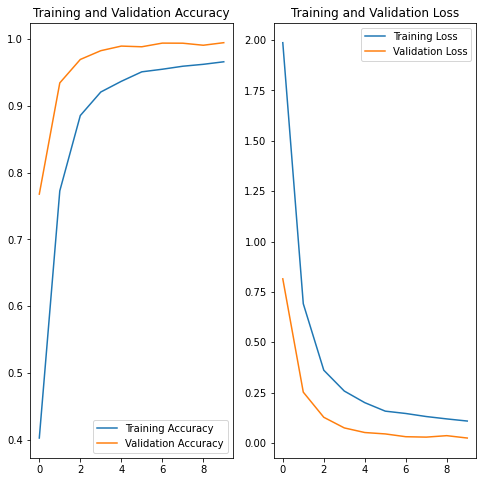

In [78]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Testing/Evaluating the model

In [79]:
#Predicting with the test data


test_ds = tf.keras.utils.image_dataset_from_directory(
    "./../kaggle/Test/",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

res = model.evaluate(test_ds)
print("test loss, test acc:", res)

Found 12630 files belonging to 43 classes.
395/395 [==============================] - 3s 7ms/step - loss: 0.2436 - accuracy: 0.9456

#### Predicting the trained model

In [80]:
img = tf.keras.preprocessing.image.load_img('../kaggle/Test/0/11812.png', target_size=img_size)
input_arr = tf.keras.preprocessing.image.img_to_array(img)
input_arr = np.array([input_arr])  # Convert single image to a batch.

predict = model.predict(input_arr)
score = tf.nn.softmax(predict[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to 0 with a 6.07 percent confidence.
